
xs: [[22156.52909274]
 [19068.95935971]
 [10086.06114759]
 [ 9034.35770667]]
us: [[300]
 [300]]
ys: [[58.28630132]
 [50.16395422]]
ds: [[100]
 [100]]


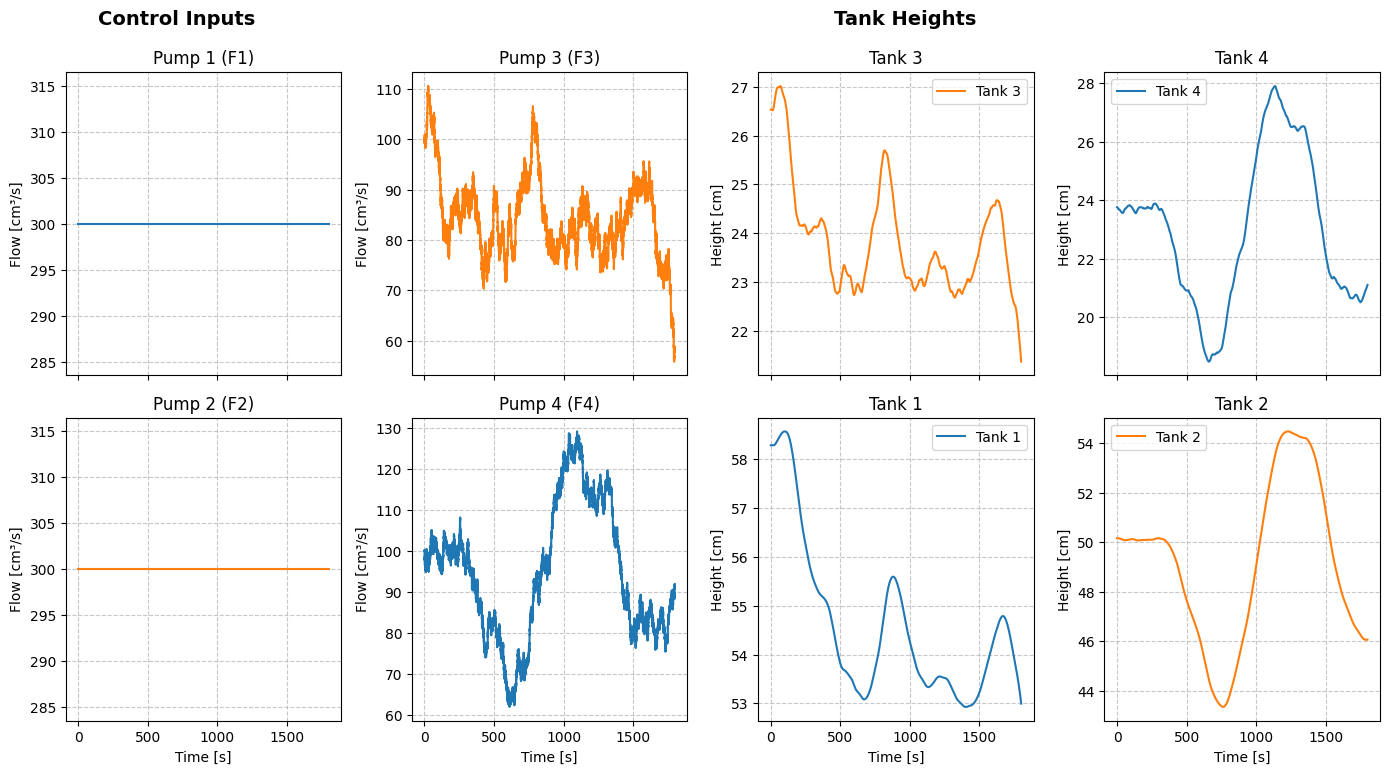

In [ ]:
from utils_functions import FourTankSystemSensor, approx_derivative
from utils_Modified_FourTank_functions import Modified_FourTankSystem
from utils_functions import *
from parameters import p
from utils_Models import OpenLoop_ModelC
from utils_DisturbanceModels import BrownianMotion
import numpy as np
from scipy.optimize import minimize
from utils_KalmanFilters import CDEKF

np.random.seed(0)

a1, a2, a3, a4, A1, A2, A3, A4, gamma1, gamma2, g, rho = p

# Initial liquid levels [cm]
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0
# Convert levels to mass [g] => m = rho * A * h
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40

x0 = np.array([m10, m20, m30, m40])  # Initial states
u0 = np.array([300,300])
d0 = np.array([100,100])

dt = 5
ts = np.arange(0,30*60+dt,dt)
N = len(ts)  # number of intervals
nx = len(x0)
F1 = np.ones_like(ts)*300
F2 = np.ones_like(ts)*300
F3 = np.ones_like(ts)*100
F4 = np.ones_like(ts)*100
u = np.array([F1,F2])
d = np.array([F3,F4])

xs = find_equilibrium(Modified_FourTankSystem, np.array([10000, 10000, 10000, 10000]), np.array([300, 300]), np.array([100, 100]), p)
Ac, Bc, Bdc, Cc, Dc = linearize_system(Modified_FourTankSystem, FourTankSystemSensor, xs, np.array([300, 300]), np.array([100, 100]), p)

#combine u and d
Bc = np.block([Bc, Bdc])
Dc = np.zeros((2,4)) #this is zero in our case

# #discretize 
_, A, B, C, D = discretize_system(Ac,Bc,Cc,Dc, Ts=dt)   
Bu = B[:,:2]
Bd = B[:,2:] 
    
xs, us, ys, ds = steady_state(Modified_FourTankSystem, np.array([10000, 10000, 10000, 10000]), np.array([300, 300]), np.array([100, 100]),p)

print(f'''
xs: {xs}
us: {us}
ys: {ys}
ds: {ds}''')

F3disturbance = BrownianMotion(sigma=1) # F3 disturbance model
F4disturbance = BrownianMotion(sigma=1) # F4 disturbance model
ModelC = OpenLoop_ModelC(ts=ts, x0=xs.ravel(), u0=u0, d0 = d0, p=p, disturbances=(F3disturbance,F4disturbance), dt_small=0.1)
T, X, H, Qout, D, Xk, Uk, Dk, Yk = ModelC.simulate()

plot_results(T, X, H, Qout, Uk, D, plot_outputs=['H'])
#Noise matrices
Rvv = np.eye(2)*2

#Test the kalman filter step by step
sigma = np.zeros((4,4))
sigma[2,2] = 1 # sigmaF3
sigma[3,3] = 1 # sigmaF4

In [3]:
class ParameterEstimationMethod:
    def __init__(self, CDEKFfilter, YnUnData, D_est):
        self.kf = CDEKFfilter
        self.data = YnUnData
        self.Dk = D_est
    
    def get_innovation_sequences(self, p):
        # given a p vector, what are the predictions from the Kalman Filter
        # Right now I just use the true disturbance as estimate
        kf = self.kf(p)
        
        Yk, Uk = self.data
        
        Ps = []
        predictions = []
        
        dt_small = dt
        n_sub = int(dt / dt_small)
        for uk, yk, dk in zip(Uk[:, 1:],Yk, self.Dk[:,1:]):
            uk = uk[:,None]
            yk = yk[:,None]
            dk = dk[:,None]
            
            Ps.append(kf.P)
            kf.measurement_update(yk)
            for _ in range(n_sub):
                kf.time_update(uk, dk, dt_small)
                predictions.append(kf.x.copy())
        
        ek = np.array(kf.ek).squeeze()
        Re_k = np.array(kf.Re_k)
        return ek, Re_k
        
    def compute_log_likelihood(self, ek, Re_k, ny=2):
        N = len(ek)
        return 1/2*np.sum(np.array([np.log(np.linalg.det(Re)+ e.T@np.linalg.inv(Re)@e) for Re, e in zip(Re_k, ek)]))+N*ny/2*np.log(2*np.pi)
    
    def V_LS(self,p):
        ek, Re_k = self.get_innovation_sequences(p)
        loss = 0.5*np.sum(np.array([e.T @ e for e in ek]))
        return loss
    
    def V_ML(self,p):
        ek, Re_k = self.get_innovation_sequences(p)
        likelihood = self.compute_log_likelihood(ek, Re_k)
        return likelihood
    
PEM = ParameterEstimationMethod(CDEKFfilter=lambda p: CDEKF(p, 
                                          Modified_FourTankSystem, 
                                          FourTankSystemSensor, 
                                          f_jacobian, 
                                          g_jacobian, 
                                          sigma, 
                                          x0=x0, 
                                          P0=np.eye(4), 
                                          Rv=Rvv), 
                          YnUnData = (Yk,Uk), 
                          D_est = Dk)

PEM.V_ML(p), PEM.V_LS(p)


(np.float64(1078.8717102996434), np.float64(38183.448354532826))

In [4]:
# parameter limits
a_min = 0.5
A_min = 350
gamma_min = 0.1
g_min = 975
rho_min = 0.8

theta_min = np.zeros_like(p)
theta_min[:4] = a_min
theta_min[4:8] = A_min
theta_min[8:10] = gamma_min
theta_min[10] = g_min
theta_min[11] = rho_min

a_max = 3
A_max = 420
gamma_max = 0.9
g_max = 1025
rho_max = 1.2

theta_max = np.ones_like(p)
theta_max[:4] = a_max
theta_max[4:8] = A_max
theta_max[8:10] = gamma_max
theta_max[10] = g_max
theta_max[11] = rho_max

Optimization using $V_{ML}$ as estimation criteria

In [13]:
p_init = np.random.multivariate_normal(mean=p, cov=np.diag(np.array([0.3]*len(p))**2))
p_init = np.clip(p_init, theta_min,theta_max)

theta0 = p_init # initial guess
theta_min = theta_min  # lower bounds
theta_max = theta_max   # upper bounds

bounds = list(zip(theta_min, theta_max))

res = minimize(PEM.V_ML, theta0, method="L-BFGS-B", bounds=bounds)

print("success:", res.success)
print("theta*:", res.x)
print("V(theta*):", res.fun)


success: False
theta*: [5.00000000e-01 1.68508226e+00 1.06742839e+00 1.27646669e+00
 3.80228241e+02 3.80406172e+02 3.80404465e+02 3.80499963e+02
 2.12553157e-01 2.28623570e-01 9.80930078e+02 1.20000000e+00]
V(theta*): 2320.489909263615


Optimization using $V_{LS}$ as estimation criteria

In [12]:
p_init = np.random.multivariate_normal(mean=p, cov=np.diag(np.array([0.3]*len(p))**2))
p_init = np.clip(p_init, theta_min,theta_max)

theta0 = p_init # initial guess
theta_min = theta_min  # lower bounds
theta_max = theta_max   # upper bounds

bounds = list(zip(theta_min, theta_max))

res = minimize(PEM.V_LS, theta0, method="L-BFGS-B", bounds=bounds)

print("success:", res.success)
print("theta*:", res.x)
print("V(theta*):", res.fun)

success: False
theta*: [1.46322503e+00 5.33652254e-01 9.54573410e-01 1.72617307e+00
 3.80455550e+02 3.80051316e+02 3.79882992e+02 3.79447386e+02
 5.16024915e-01 6.00911358e-01 9.80714722e+02 8.00000000e-01]
V(theta*): 6369131.313803251
